# This notebook
<PRE>
This Jupyter notebook was created as a homework assignment for the course
"Deep Learning a gyakorlatban Python és LUA alapon" at the Budapest University of Technology and Economics.

Authors:
- Bilicki Vilmos (BLU8CF)
- Goldschmidt Olivér (RXL623)
- Szabó Tamás János (DN5FXS)
</PRE>


# Download data

## Requirements

This libary is for audio augmentation (pitch, noise, etc.):

In [ ]:
!pip install audiomentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: soxr
    Found existing installation: soxr 1.0.0
    Uninstalling soxr-1.0.0:
      Successfully uninstalled soxr-1.0.0


## Downloading traning metadata and sounds

In [ ]:
import os
os.chdir('.')

In [ ]:
#!gdown 1XSD6tDkdm7qd_5SQkUMhEW15fMxaZKo9 -O "train_data.zip"
!gdown 1bsIIwv_jLH33mwxd_c3qP9MgK46PX1aO -O "train_data.zip"

Downloading...
From (original): https://drive.google.com/uc?id=1bsIIwv_jLH33mwxd_c3qP9MgK46PX1aO
From (redirected): https://drive.google.com/uc?id=1bsIIwv_jLH33mwxd_c3qP9MgK46PX1aO&confirm=t&uuid=97832b47-22f7-4b1e-9791-1549794fc8da
To: /content/train_data.zip
100% 7.80G/7.80G [01:39<00:00, 78.7MB/s]


In [ ]:
!unzip -q "/content/train_data.zip"

# Initialize

In [ ]:
# setting seed and default imports for reproducibility
import numpy as np
import tensorflow as tf
import pandas as pd
import random

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
# load metadata
train_metadata = pd.read_csv("train_metadata.csv")

# add filepath
train_metadata["filename"] = train_metadata["filename"].apply(
    lambda fn: os.path.join("/content/train_audio", fn)
)

# using only label and filepath
df = train_metadata[["primary_label", "filename"]]

# print
train_metadata.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,/content/train_audio/asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,/content/train_audio/asbfly/XC164848.ogg
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,/content/train_audio/asbfly/XC175797.ogg
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,/content/train_audio/asbfly/XC207738.ogg
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,/content/train_audio/asbfly/XC209218.ogg


## Distribution

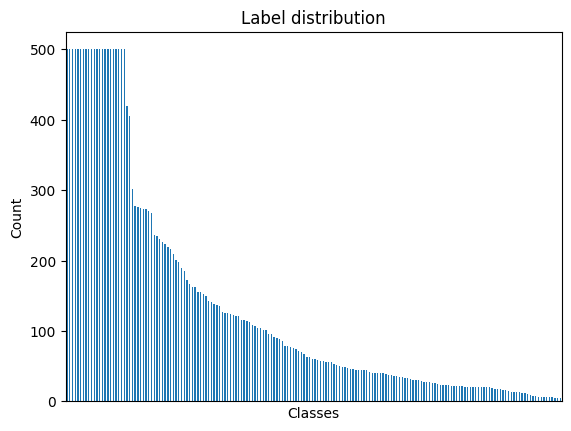

In [ ]:
# Plot Label distribution
import matplotlib.pyplot as plt

def plot_dist(dataframe):
    label_counts = dataframe['primary_label'].value_counts()
    label_counts.plot(kind='bar')
    plt.title("Label distribution")
    plt.xlabel("Classes")
    plt.xticks([])
    plt.ylabel("Count")
    plt.show()

plot_dist(df)

## Debug function

In [ ]:
DEBUG = False
def dbg(debug_message):
    if DEBUG:
        print(debug_message)

# Data loading

## Parameters for reading sound file and converting to spectogram

In [ ]:
sample_rate = 32000     # sampling rate (Hz)
n_fft = 2048            # FFT window size (number of samples per FFT)
hop_length = 512        # hop size between FFT windows (in samples)
n_mels = 128            # number of mel frequency bands
fmin = 0                # minimum frequency (Hz) included in the mel spectrogram
fmax = sample_rate / 2  # maximum frequency (Hz), Nyquist frequency; limits the highest frequency represented

## Mel spectrogram visualization utilities

In [ ]:
import librosa          # audio loading and signal processing
import librosa.display  # visualization helpers for spectrograms

# Display a mel spectrogram (in dB scale)
def show_spectogram(S_dB, filename=""):
    # create a plot using the dB of sound
    librosa.display.specshow(S_dB, sr=sample_rate, x_axis='time', y_axis='mel', cmap='magma', fmin=fmin, fmax = fmax)
    plt.colorbar(format='%+2.0f dB')            # show color scale in decibels
    plt.title(f"Mel Spectrogram — {filename}")  # plot title
    plt.tight_layout()                          # for a better look
    plt.show()

# Load an audio file and display its mel spectrogram
def show_audio(filename):
    print(f"Showing spectrogram for: {filename}")

    # load the audio file
    y, sr = librosa.load(filename, sr=sample_rate)

    # compute power mel spectrogram
    S = librosa.feature.melspectrogram(
        y=y,            # audio waveform
        sr=sample_rate, # sampling rate
        n_fft=n_fft,    # FFT window size
        hop_length=hop_length, # hop size between FFT frames
        n_mels=n_mels,  # number of mel frequency bands
        fmin=fmin,      # minimum frequency
        fmax=fmax       # maximum frequency
    )

    # convert power spectrogram to logarithmic dB scale
    S_dB = librosa.power_to_db(S, ref=np.max)

    # showing the loaded spectogram
    show_spectogram(S_dB, filename)

## Audio loading and mel spectrogram preprocessing

In [ ]:
from tensorflow.keras.applications.convnext import preprocess_input # ConvNeXt-specific input normalization

# Load an audio file as a mono waveform
def load_audio(path):
    y, _ = librosa.load(
        path,           # path for audio file
        sr=sample_rate, # resample audio
        mono=True,      # use mono channel
        duration=None,  # load the full file
    )
    return y


# Convert waveform to mel spectogram
def audio_to_mel(y):
     # compute power mel spectrogram
    mel = librosa.feature.melspectrogram(
        y=y,            # audio waveform
        sr=sample_rate, # sampling rate
        n_fft=n_fft,    # FFT window size
        hop_length=hop_length, # hop size between frames
        n_mels=n_mels,  # number of mel frequency bands
        fmin=fmin,      # minimum frequency
        fmax=fmax       # maximum frequency
    )

    # convert power spectrogram to logarithmic dB scale
    mel_db = librosa.power_to_db(mel, ref=np.max)

    return mel_db.astype(np.float32) # ensure float32 for TensorFlow

# Normalize mel spectrogram for model input
def normalize_mel(y):
    return preprocess_input(y) # for ConvNeXt-Tiny
    # for our own convnet:
    # mel_db_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min()) * 2.0 - 1.0

## Audio chunking and silence filtering

In [ ]:
# Split a waveform into overlapping fixed-length chunks
def slice_audio(y, window, step):
    win_length = int(window * sample_rate) # window size in samples
    step_length = int(step * sample_rate)  # step size in samples

    slices = [] # list of waveform chunks
    # iterate over the audio with a sliding window
    for start in range(0, max(1, len(y) - win_length + 1), step_length):
        end = start + win_length
        y_slice = y[start:end]  # extract audio chunk

        # padding with zeros if chunk is too short
        if len(y_slice) < win_length:
            y_slice = np.pad(y_slice, (0, win_length - len(y_slice)))

        slices.append(y_slice) # append result list

    return slices

In [ ]:
# Remove chunks with very low signal energy (near silence)
def remove_silent_chunks(chunks, threshold=0.01):
    kept_chunks = []
    for chunk in chunks:
        max_val = np.max(chunk)     # peak amplitude of the chunk
        if max_val > threshold:     # keep chunk only if it exceeds the silence threshold
            kept_chunks.append(chunk)
    return kept_chunks # return kept chunks

## Audio and spectrogram data augmentation

In [ ]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, OneOf, HighPassFilter, BandPassFilter, ClippingDistortion

# Audio augmentation pipeline
augmenter = Compose([
    # randomly apply either time stretching or pitch shifting
    OneOf([
        TimeStretch(
            min_rate=0.95,  # minimum playback speed
            max_rate=1.15,  # maximum playback speed
            leave_length_unchanged=True # keep waveform length fixed
        ),
        PitchShift(
            min_semitones=-1.5, # pitch shift down (halftones)
            max_semitones=1.5   # pitch shift up (halftones)
        ),
    ], p=0.4), # probability of applying one of these

    # add low-level Gaussian noise (for simulating background noise)
    AddGaussianNoise(min_amplitude=0.0005, max_amplitude=0.008, p=0.3),

    # frequency distortion
    OneOf([
        HighPassFilter(min_cutoff_freq=200, max_cutoff_freq=1200),  # remove low frequencies below cutoff
        BandPassFilter(min_center_freq=2000, max_center_freq=8000), # emphasize a mid/high frequency band, where birds sing
    ], p=0.4),

    # simulatnig clipping distortion with probabilty of 0.1 (overloaded microphone)
    ClippingDistortion(max_percentile_threshold=20, p=0.1),

])

# apply augmentations to audio
def apply_audio_augmentations(y):
    return augmenter(samples=y, sample_rate=sample_rate)

In [ ]:
# Apply frequency masing on a given spectogram
def spec_augment(mel, time_mask_param=10, freq_mask_param=6, num_time_masks=2, num_freq_masks=1):
    # mel: numpy array (n_mels, time_steps)

    m = mel.copy() # to avoid modifying original input
    n_mels, t = m.shape

    # vertical stripes
    for _ in range(num_freq_masks):
        f = np.random.randint(0, freq_mask_param)   # mask width (mel bins)
        f0 = np.random.randint(0, n_mels - f + 1)   # start index
        m[f0:f0+f, :] = 0                           # apply mask
    # horizontal stripes
    for _ in range(num_time_masks):
        tt = np.random.randint(0, time_mask_param)  # mask width (time steps)
        t0 = np.random.randint(0, t - tt + 1)       # start index
        m[:, t0:t0+tt] = 0                          # apply mask
    return m

## Balanced dataset generator

In [ ]:
from collections import defaultdict

# TensorFlow autotuning for parallelism and prefetching
AUTOTUNE = tf.data.AUTOTUNE

# Create a balanced tf.data.Dataset that yields mel-spectrogram patches and single-class targets
def create_balanced_dataset(dataframe, is_training, batch_size, threshold, name):

    # enable shuffling and augmentation only during training
    shuffle = is_training
    augment = is_training

    def generator():
        # using outer variables of the enclosure
        nonlocal filepaths, labels, num_classes, chunk_counter, epoch_counter

        dbg(f"\nstart generator: {name}")

        # map each class index to its list of audio file paths
        original_class_to_filepaths = defaultdict(list)

        for fp, class_idx in zip(filepaths, labels): # load original_class_to_filepaths
            original_class_to_filepaths[class_idx].append(fp)

        original_class_to_filepaths = dict(original_class_to_filepaths) # convert to dict

        dbg(f"original_class_to_filepaths: {name}: {original_class_to_filepaths}")
        dbg(f"chunk_counter: {name}: {chunk_counter}")

        # main epoch loop
        while True:

            # select next class index by lowest number of produced chunks
            idx = chunk_counter.argmin()

            # choosing a file to load from the selected class
            fp = random.choice( original_class_to_filepaths[idx] )

            # debug message
            dbg(f"load: {name}: {fp}")

            # loading the audio file
            y = load_audio(fp)

            # splitting into overlapping chunks
            chunks = slice_audio(y, window=5.0, step=4.0)

            # shuffling chunks of the loaded file
            if shuffle:
                random.shuffle(chunks)

            # removing silent chunks
            chunks = remove_silent_chunks(chunks)

            # skip and remove file if all chunks are silent
            if(len(chunks) == 0):
                dbg(f'skip audio: {name}: {fp}')
                try:
                    original_class_to_filepaths[idx].remove(fp) # remove from files
                except Exception:
                    pass


            finished_class = False # flag for reaching threshold

            # iterating over chunks
            for audio_chunk in chunks:

                if(finished_class):
                    break

                # apply waveform level augmentation
                if augment:
                    audio_chunk = apply_audio_augmentations(audio_chunk)

                # convert audio to spectogram
                mel = audio_to_mel(audio_chunk)

                # apply spectogram level augmentation
                if augment:
                    mel = spec_augment(mel)

                # transpose to (time, mel)
                mel_T = mel.T

                # fix time dimension
                target_time = 320
                if mel_T.shape[0] < target_time:
                    mel_T = np.pad(mel_T, ((0, target_time - mel_T.shape[0]), (0,0)))
                else:
                    mel_T = mel_T[:target_time]

                # convert to image-like tensor (H, W, C)
                img = np.expand_dims(mel_T, -1).astype(np.float32)
                img = np.repeat(img, 3, axis=-1)

                # normalize spectrogram for model input
                img = normalize_mel(img)

                # increase per-class chunk counter
                chunk_counter[idx] += 1

                # if current class reached threshold
                if(chunk_counter[idx] >= threshold*epoch_counter):
                    finished_class = True

                yield img, np.int32(idx)

            # epoch termination check
            chunk_counter_threshold = chunk_counter.min()
            dbg(f"\nchunk_counter_threshold: {name}: {chunk_counter_threshold}")

            # if threshold is reached, we end the epoch
            if(chunk_counter_threshold >= (threshold * epoch_counter )):
                dbg(f"\nthreshold reached: {name}")
                epoch_counter += 1
                break

    # dataset initialization
    # extract file paths
    filepaths = dataframe["filename"].values

    # create class index mapping
    unique_classes = sorted(dataframe['primary_label'].unique())
    class_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}
    labels = np.array([class_to_idx[label] for label in dataframe['primary_label'].values])
    num_classes = len(unique_classes)

    # initialize counters
    epoch_counter = 1
    chunk_counter = np.zeros((num_classes), dtype=np.float64)

    # define generator output signature
    output_signature = (
        tf.TensorSpec(shape=(None, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    # create tf.data.Dataset from generator
    ds = tf.data.Dataset.from_generator(generator, output_signature=output_signature)

    # shuffle dataset if training
    if shuffle:
        ds = ds.shuffle(buffer_size=BATCH_SIZE*2, seed=SEED)

    # batch and prefetch for performance
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

# Preprocessing

## Train / Test split

train / valid classes: 182 test classes: 182
Train / valid


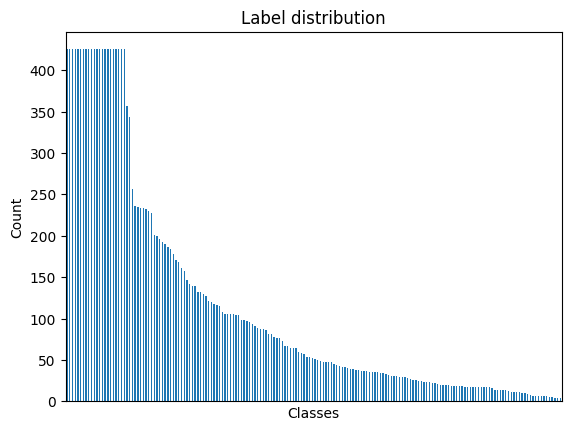

Test


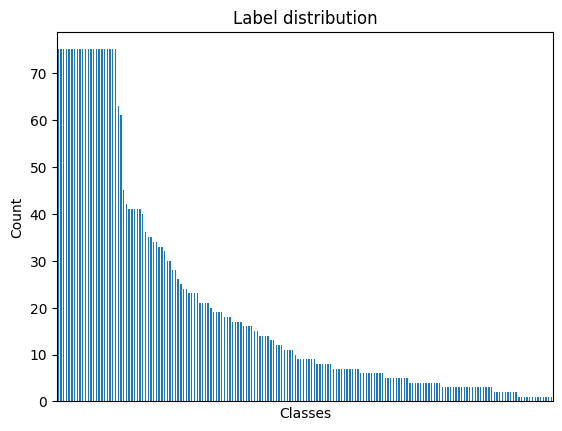

In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset into train/validation pool and test set
X_train, X_test, y_train, y_test = train_test_split(
    df['filename'],
    df["primary_label"],
    test_size=0.15,
    random_state=42,
    stratify=df['primary_label']
)

# Construct training/validation dataframe
df_train_valid = pd.DataFrame({
    'filename': X_train.values,
    'primary_label': y_train.values
})

# Construct test dataframe
df_test = pd.DataFrame({
    'filename': X_test.values,
    'primary_label': y_test.values
})

# Count unique classes in each split
num_classes_train_valid = len(df_train_valid['primary_label'].unique())
num_classes_test = len(df_test['primary_label'].unique())

# Ensure all classes are present in both splits
print("train / valid classes:", num_classes_train_valid, "test classes:", num_classes_test)
assert num_classes_train_valid == num_classes_test, "Number of classes are not equal!"

# Visualization
print("Train / valid")
plot_dist(df_train_valid)
print("Test")
plot_dist(df_test)


 ## Stratified cross-validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Cross-validation configuration
STRATIFIED = True
N_FOLDS = 4

# Initialize stratified K-fold splitter
kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

# Store fold indices
fold_splits = []

# Generate train/validation splits for each fold
for fold_idx, (train_idx, val_idx) in enumerate( kfold.split(df_train_valid, df_train_valid['primary_label'] if STRATIFIED else None) ):
    fold_splits.append({
        'fold_idx': fold_idx + 1,
        'train_idx': train_idx.copy(),
        'val_idx': val_idx.copy()
    })
    # Print fold statistics
    print(f"  Fold {fold_idx + 1}: Train={len(train_idx)}, Val={len(val_idx)}")

    # Show first 5 validation indices for this fold (for verification)
    print(f"    First 5 val indices: {val_idx[:5].tolist()}")

  Fold 1: Train=15592, Val=5198
    First 5 val indices: [3, 4, 8, 12, 13]
  Fold 2: Train=15592, Val=5198
    First 5 val indices: [2, 11, 14, 24, 30]
  Fold 3: Train=15593, Val=5197
    First 5 val indices: [5, 7, 9, 15, 17]
  Fold 4: Train=15593, Val=5197
    First 5 val indices: [0, 1, 6, 10, 20]


# Model

## Model hyperparameters

In [ ]:
import math

def suggest_threshold(
    num_classes,
    batch_size,
    min_threshold=1,
    max_threshold=10_000
):
    # Find the smallest threshold such that:
    # (threshold × num_classes) is divisible by batch_size
    # This guarantees an integer number of steps per epoch.

    for t in range(min_threshold, max_threshold + 1):
        if (t * num_classes) % batch_size == 0:
            return t
    raise ValueError("No valid THRESHOLD found in range")


In [ ]:
# Training configuration
BATCH_SIZE = 16         # number of chunks per training step
TRAIN_THRESHOLD = 128   # number of chunks per class per training epoch -> one training epoch contains TRAIN_THRESHOLD * num_classes * BATCH_SIZE  chunk
VALID_THRESHOLD = 32    # number of chunks per class per validation epoch -> one validation epoch contains VALID_THRESHOLD * num_classes * BATCH_SIZE chunk
EPOCHS = 30             # total number of training epochs

# Number of unique classes
num_classes = len(df_train_valid['primary_label'].unique())

# Compute steps per epoch
# (threshold * num_classes) samples total per epoch
steps_per_train_epoch = (TRAIN_THRESHOLD * num_classes) // BATCH_SIZE
steps_per_valid_epoch = (VALID_THRESHOLD * num_classes) // BATCH_SIZE

# Sanity check: ensure divisibility for clean epoch boundaries
assert ((TRAIN_THRESHOLD * num_classes) % BATCH_SIZE) == 0 , f"\nmodify TRAIN_THRESHOLD or BATCH_SIZE for divisibility:\n (num_classes){num_classes} * {TRAIN_THRESHOLD}(TRAIN_THRESHOLD) = {num_classes*TRAIN_THRESHOLD} is not devidable with (BATCH_SIZE){BATCH_SIZE}\nSuggested TRAIN_THRESHOLD: {suggest_threshold(num_classes, BATCH_SIZE)} or any multiplicate by {num_classes} or {BATCH_SIZE}"
assert ((VALID_THRESHOLD * num_classes) % BATCH_SIZE) == 0 , f"\nmodify VALID_THRESHOLD or BATCH_SIZE for divisibility:\n (num_classes){num_classes} * {VALID_THRESHOLD}(VALID_THRESHOLD) = {num_classes*VALID_THRESHOLD} is not devidable with (BATCH_SIZE){BATCH_SIZE}\nSuggested VALID_THRESHOLD: {suggest_threshold(num_classes, BATCH_SIZE)} or any multiplicate by {num_classes} or {BATCH_SIZE}"

# Print final epoch sizes
print("steps_per_train_epoch:", steps_per_train_epoch)
print("steps_per_valid_epoch:", steps_per_valid_epoch)

steps_per_train_epoch: 1456
steps_per_valid_epoch: 364


## Model definition

In [ ]:
# Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pandas as pd
from tensorflow.keras.applications import ConvNeXtTiny

# Model factory
def create_model(num_classes, trainable_base=False, learning_rate=1e-3):

    # load ConvNeXt-Tiny backbone pretrained on ImageNet
    base_model = keras.applications.ConvNeXtTiny(
        include_top=False,          # remove ImageNet classifier head
        weights="imagenet",         # use pretrained weights on ImageNet
        input_shape=(320, 128, 3),  # spectrogram image shape
        pooling="avg"               # global average pooling
    )

    # freeze or unfreeze all backbone layers (freeze: stage I, unfreeze: stage II)
    for layer in base_model.layers:
        layer.trainable = trainable_base

    # our custom classification head
    x = layers.Dense(1024, activation="relu")(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # softmax classifier
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # assemble model
    model = models.Model(
        inputs=base_model.input,
        outputs=outputs
    )

    # compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=[ tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5')]
    )

    return model



## Stage I

With **freezed backbone** traning classifier head

Starting Fold 1/4


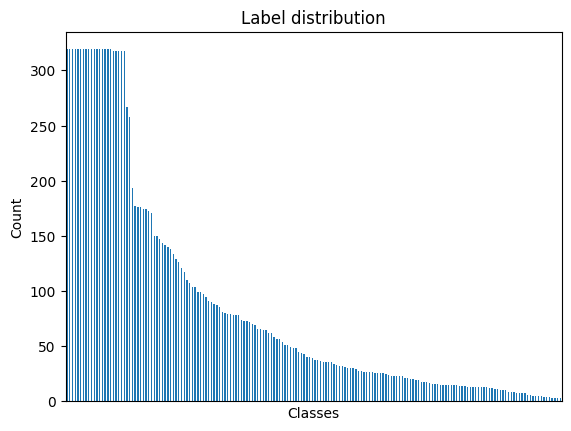

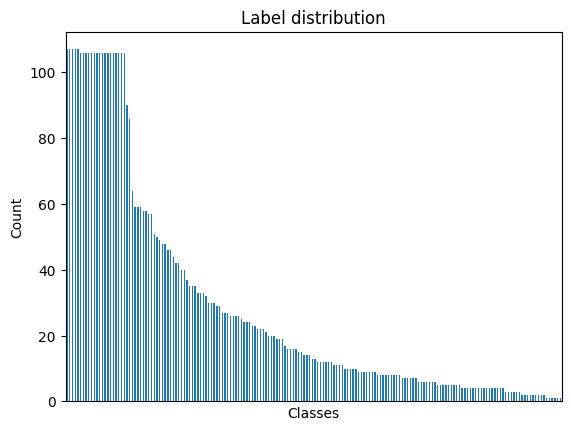

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_pres… │ (None, 320, 128,  │          0 │ input_layer[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stem  │ (None, 80, 32,    │      4,896 │ convnext_tiny_pr… │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 80, 32,    │      4,800 │ convnext_tiny_st… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 80, 32,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 80, 32,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 80, 32,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 80, 32,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 80, 32,    │         96 │ convnext_tiny_st… │
│ (LayerScale)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 80, 32,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 80, 32,    │          0 │ convnext_tiny_st… │
│                     │ 96)               │            │ convnext_tiny_st… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 80, 32,    │      4,800 │ add[0][0]         │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 80, 32,    │        192 │ convnext_tiny_st… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 80, 32,    │     37,248 │ convnext_tiny_st… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 80, 32,    │          0 │ convnext_tiny_st… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 80, 32,    │     36,960 │ convnext_tiny_st… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_tiny_stag… │ (None, 80, 32,    │         96 │ convnext_tiny_st

 Total params: 29,231,894 (111.51 MB)

 Trainable params: 1,408,694 (5.37 MB)

 Non-trainable params: 27,823,200 (106.14 MB)

Epoch 1/30
  26/1456 ━━━━━━━━━━━━━━━━━━━━ 10:40:45 27s/step - accuracy: 0.0426 - loss: 5.8885 - top5: 0.1270

In [ ]:
# Cross-validation storage
all_fold_histories = []
all_fold_metrics = []

# Number of classes
num_classes = len(df_train_valid['primary_label'].unique())

# Cross-validation loop
for fold in range(N_FOLDS):
    print("="*80)
    print(f"Starting Fold {fold+1}/{N_FOLDS}")
    print("="*80)

    # --- 1) Extract train/validation indices for this fold
    train_idx = fold_splits[fold]['train_idx']
    val_idx = fold_splits[fold]['val_idx']

    # Build fold-specific dataframes
    df_train = df_train_valid.iloc[train_idx].reset_index(drop=True)
    df_valid = df_train_valid.iloc[val_idx].reset_index(drop=True)

    # Plot class distributions (sanity check)
    plot_dist(df_train)
    plot_dist(df_valid)

    # Create balanced tf.data datasets
    ds_train = create_balanced_dataset(df_train, is_training=True, batch_size=BATCH_SIZE, threshold=TRAIN_THRESHOLD, name='train')
    ds_valid = create_balanced_dataset(df_valid, is_training=False, batch_size=BATCH_SIZE, threshold=VALID_THRESHOLD, name='valid')

    # Training dataset is infinite -> controlled by steps_per_epoch
    ds_train = ds_train.repeat()


    # --- 2) Callbacks
    callbacks = [
        # stop training when validation accuracy stops improving
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        # save best model per fold
        keras.callbacks.ModelCheckpoint(
            filepath=f'best_model_dl_Fold_{fold + 1}_STAGE_I.weights.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        # reduce learning rate when validation loss plateaus
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=1e-7,
            verbose=1
        ),
        # tensorboard logging
        keras.callbacks.TensorBoard(
            log_dir=f'logs/fold_{fold+1}',
            histogram_freq=1,
            write_graph=1
        )
    ]

    # --- 3) model creation
    model = create_model(
        num_classes,            # number of classes
        trainable_base=False,   # freeze all backbone layers (Stage I / transfer learning)
        learning_rate=1e-3      # higher learning rate for classifier head
    )

    model.summary()

    # --- 4) Model training STAGE I: classifier head
    history = model.fit(
        ds_train,
        validation_data=ds_valid,
        steps_per_epoch=steps_per_train_epoch,
        validation_steps=steps_per_valid_epoch,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

    # --- 5) Evaluation
    fold_metrics = model.evaluate(ds_valid, verbose=0)

    print(f"Fold {fold+1} result:")
    print(f"  val_loss = {fold_metrics[0]:.4f}")
    print(f"  val_acc  = {fold_metrics[1]:.4f}")

    all_fold_histories.append(history.history)
    all_fold_metrics.append(fold_metrics)

    # --- 6) Save final model for this fold
    model.save(f"model_fold_stage_1_dl_{fold+1}.weights.keras")


print("Cross-validation finished.")

# Aggregate cross-validation results
val_losses = [m[0] for m in all_fold_metrics]
val_accs   = [m[1] for m in all_fold_metrics]

print("\n===== FINAL CROSS-VALIDATION RESULT =====")
print(f"Average val_loss: {np.mean(val_losses):.4f} ± {np.std(val_losses):.4f}")
print(f"Average val_acc :  {np.mean(val_accs):.4f} ± {np.std(val_accs):.4f}")

## Stage II

Unfreezed backbone, finetuning

In [ ]:
# Cross-validation storage
all_fold_histories = []
all_fold_metrics = []

# Number of classes
num_classes = len(df_train_valid['primary_label'].unique())

# Cross-validation loop
for fold in range(N_FOLDS):
    print("="*80)
    print(f"Starting Fold {fold+1}/{N_FOLDS}")
    print("="*80)

    # --- 1) Extract train/validation indices for this fold
    train_idx = fold_splits[fold]['train_idx']
    val_idx = fold_splits[fold]['val_idx']

    # Build fold-specific dataframes
    df_train = df_train_valid.iloc[train_idx].reset_index(drop=True)
    df_valid = df_train_valid.iloc[val_idx].reset_index(drop=True)

    # Plot class distributions (sanity check)
    plot_dist(df_train)
    plot_dist(df_valid)

    # Create balanced tf.data datasets
    ds_train = create_balanced_dataset(df_train, is_training=True, batch_size=BATCH_SIZE, threshold=TRAIN_THRESHOLD, name='train')
    ds_valid = create_balanced_dataset(df_valid, is_training=False, batch_size=BATCH_SIZE, threshold=VALID_THRESHOLD, name='valid')

    # Training dataset is infinite -> controlled by steps_per_epoch
    ds_train = ds_train.repeat()


    # --- 2) Callbacks
    callbacks = [
        # Stop training when validation accuracy stops improving
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        # Save best model per fold
        keras.callbacks.ModelCheckpoint(
            filepath=f'best_model_dl_Fold_{fold + 1}_STAGE_II.weights.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        # Reduce learning rate when validation loss plateaus
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=1e-7,
            verbose=1
        ),
        # TensorBoard logging
        keras.callbacks.TensorBoard(
            log_dir=f'logs/fold_{fold+1}',
            histogram_freq=1,
            write_graph=1
        )
    ]

    # --- 3) Model creation
    model = create_model(
        num_classes,            # number of classes
        trainable_base=True,    # unfreeze all backbone layers (Stage II)
        learning_rate=4e-5      # low learning rate for fine-tuning
    )

    # Load pretrained Stage I weights
    model.load_weights(f'model_fold_stage_1_dl_{fold+1}.weights.keras')

    model.summary()

    # --- 4) Model training STAGE II: fine-tuning
    history = model.fit(
        ds_train,
        validation_data=ds_valid,
        steps_per_epoch=steps_per_train_epoch,
        validation_steps=steps_per_valid_epoch,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

    # --- 5) Evaluation
    fold_metrics = model.evaluate(ds_valid, verbose=0)

    print(f"Fold {fold+1} result:")
    print(f"  val_loss = {fold_metrics[0]:.4f}")
    print(f"  val_acc  = {fold_metrics[1]:.4f}")

    all_fold_histories.append(history.history)
    all_fold_metrics.append(fold_metrics)

    # --- 6) Save final model for this fold
    model.save(f"model_fold_stage_2_dl_{fold+1}.weights.keras")



print("Cross-validation finished.")

# Aggregate cross-validation results
val_losses = [m[0] for m in all_fold_metrics]
val_accs   = [m[1] for m in all_fold_metrics]

print("\n===== FINAL CROSS-VALIDATION RESULT =====")
print(f"Average val_loss: {np.mean(val_losses):.4f} ± {np.std(val_losses):.4f}")
print(f"Average val_acc :  {np.mean(val_accs):.4f} ± {np.std(val_accs):.4f}")

# Final model evaluation

## Test dataset creation

In [ ]:
# Create a tf.data.Dataset for test-time inference
# No augmentation, no balancing, full coverage of audio files
def create_test_dataset(dataframe, batch_size):

    def generator():
        # iterate over all test files and their class indices
        for fp, idx in zip(filepaths, labels):

            # load full audio file
            y = load_audio(fp)

            # slice audio into overlapping chunks
            chunks = slice_audio(y, window=5.0, step=4.0)

            # iterate over chunks
            for audio_chunk in chunks:

                # Convert chunk to mel spectrogram
                mel = audio_to_mel(audio_chunk)
                mel_T = mel.T

                # fix time dimension to target length
                target_time = 320
                if mel_T.shape[0] < target_time:
                    mel_T = np.pad(
                        mel_T,
                        ((0, target_time - mel_T.shape[0]), (0, 0))
                    )
                else:
                    mel_T = mel_T[:target_time]

                # convert to image-like tensor (H, W, C)
                img = np.expand_dims(mel_T, -1).astype(np.float32)
                img = np.repeat(img, 3, axis=-1)

                # normalize for ConvNeXt input
                img = normalize_mel(img)

                # yield spectrogram and ground-truth class index
                yield img, idx


    # Dataset initialization

    # Extract file paths
    filepaths = dataframe["filename"].values

    # Create class -> index mapping
    unique_classes = sorted(dataframe["primary_label"].unique())
    class_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}
    # Encode labels as integer class indices
    labels = np.array(
        [class_to_idx[label] for label in dataframe["primary_label"].values],
        dtype=np.int32
    )
    assert len(unique_classes) == 182, "all classes are needed"

    # Define generator output signature
    output_signature = (
        tf.TensorSpec(shape=(320, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    # Build tf.data.Dataset
    ds = tf.data.Dataset.from_generator(
        generator,
        output_signature=output_signature
    )

    # Batch and prefetch for efficient inference
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [ ]:
# Fraction to take
frac = 1  # 100% of the dataset

# Stratified sampling: sample frac from each class
df_test_sampled = (
    df_test
    .groupby('primary_label', group_keys=False)
    .apply(lambda x: x.sample(frac=frac, random_state=42))
    .reset_index(drop=True)
)

# Create test dataset
ds_test = create_test_dataset(df_test_sampled, batch_size=128)

/tmp/ipython-input-2702202908.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=frac, random_state=42))


## Model loading and evaluation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Recreate model architecture
model = create_model(num_classes = 182)


# Load trained Stage II weights
model.load_weights('model.weights.keras')

# Compile model for evaluation
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=[ tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5')]
)

# Evaluate model
loss, acc, top5 = model.evaluate(ds_test)
print(f"Top-1 accuracy: {acc*100:.2f}%")
print(f"Top-5 accuracy: {top5*100:.2f}%")



111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 382 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


262/262 ━━━━━━━━━━━━━━━━━━━━ 777s 3s/step - accuracy: 0.5971 - loss: 1.8579 - top5: 0.7679
Top-1 accuracy: 61.87%
Top-5 accuracy: 78.41%


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
